In [1]:
import pandas as pd
import numpy as np


In [2]:
ratings = pd.read_csv('rating.csv') # reading data in pandas df

from surprise import Reader, Dataset

# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

len(df)

20000263

In [3]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.model_selection import train_test_split
df = df.head(10000000)
#X_train, X_test = train_test_split(df)

clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25], epochs=1, loss='mean_absolute_error')
clf1.fit(df)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                100       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=1,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1, loss='mean_absolute_error', optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

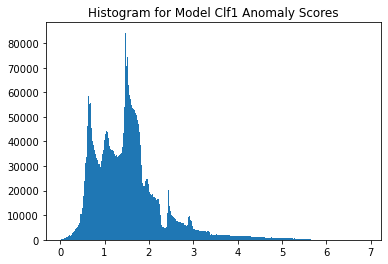

In [4]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf1.decision_function(df)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [5]:
df['score'] = y_test_scores
df['cluster'] = np.where(df['score']<2.3, 0, 1)
df
#df_test['cluster'].value_counts()

#df_test.groupby('cluster').mean()


,itemID,userID,rating,score,cluster
0,2,1,3.5,1.778489,0
1,29,1,3.5,1.778139,0
2,32,1,3.5,1.778101,0
3,47,1,3.5,1.777907,0
4,50,1,3.5,1.777868,0
...,...,...,...,...,...
9999995,1234,69139,5.0,2.266229,0
9999996,1240,69139,4.0,1.837001,0
9999997,1244,69139,5.0,2.266141,0
9999998,1246,69139,5.0,2.266123,0


In [6]:
df_GS = df[df['cluster'] == 1]
df_no_GS = df[df['cluster'] == 0]
df = df.drop(['score', 'cluster'], axis=1)
df_no_GS = df_no_GS.drop(['score', 'cluster'], axis=1)
df_GS = df_GS.drop(['score', 'cluster'], axis=1)
print(len(df_GS))
def get_weights():
    return df['score']

1260731


In [7]:
#from sklearn.neighbors import NearestNeighbors
#neigh = NearestNeighbors(n_neighbors=20, weights=get_weights)
#neigh.fit(df[['userID', 'itemID']], df['rating'])

In [8]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
data_no_GS = Dataset.load_from_df(df_no_GS[['userID', 'itemID', 'rating']], reader)
data_GS = Dataset.load_from_df(df_GS[['userID', 'itemID', 'rating']], reader)

In [ ]:
print((type(data)))
#data.split(n_folds=5)

from surprise import SVD
from surprise import NMF
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import cross_validate



algo = KNNBasic(k=20)
#algo = NMF()
#algo = SVD()

#CF on ALL users
cross_validate(algo, data, measures=['MAE'], cv=5, verbose=True)

<class 'surprise.dataset.DatasetAutoFolds'>
Computing the msd similarity matrix...


In [ ]:
df_no_GS

In [ ]:
#CF on the grey sheep users
cross_validate(algo, data_GS, measures=['MAE'], cv=5, verbose=True)

In [ ]:
#CF on everyone BUT the grey sheep users
cross_validate(algo, data_no_GS, measures=['MAE'], cv=5, verbose=True)